In [38]:
import json
import os
import re
import sys
import warnings

import cv2
import imageio
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from PIL import Image, ImageFilter
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.linear_model import LogisticRegression
from scipy.misc import imresize
from skimage import feature, color
%matplotlib inline

# Hide scikit-learn warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def file_list(start_dir):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start_dir):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list

def compile_chat(chat_path, seconds_per_bin=60):
    def agg_chat(data):
        """Aggregate JSON chat data into a row"""
        attr = data['attributes']

        timestamp = attr['timestamp']
        message = attr['message']
        author = attr['from']
        turbo = attr['tags']['turbo']
        sub = attr['tags']['subscriber']

        try:
            emotes = attr['tags']['emotes']
            emote_count = sum([len(emotes[key]) for key in emotes.keys()])
        except:
            emote_count = 0

        row = {
            'timestamp': timestamp,
            'author': author,
            'message': message,
            'turbo': turbo,
            'sub': sub,
            'emote_count': emote_count
        }

        return row

    def agg_emotes(data):
        """Aggregate JSON chat emotes into a row"""
        attr = data['attributes']

        timestamp = attr['timestamp']

        try:
            emotes = attr['tags']['emotes']
            rows = []
            for key in emotes.keys():
                rows.append(
                    {
                        'timestamp': timestamp,
                        'emote': key,
                        'count': len(emotes[key])
                    }
                )
            return rows
        except AttributeError:
            return [{'timestamp': timestamp,
                    'emote': 0,
                    'count': 0
                   }]

    # Aggregate files into dictionary
    aggregate_chat = []
    aggregate_emotes = []
    for f in file_list(chat_path):
        get_path = os.path.join(chat_path, f)
        with open(get_path) as c:

            # Format line and separate multiple JSON strings with commas
            line = '[{}]'.format(c.readline()).replace('}}{', '}},{')
            data = json.loads(line)[0]

            for message in data['data']:
                aggregate_chat.append(agg_chat(message))
                aggregate_emotes.extend(agg_emotes(message))

    # Build data frame from chat results
    df_chat = pd.DataFrame(aggregate_chat)
    minimum = df_chat['timestamp'].min()
    maximum = df_chat['timestamp'].max()
    df_chat['timestamp'] = df_chat['timestamp'].apply(lambda x: x - minimum)
    df_chat['secondstamp'] = df_chat['timestamp'].apply(
        lambda x: int(round(x/1000/seconds_per_bin)*seconds_per_bin)
    )
    
    # Build data frame from chat results
    df_emotes = pd.DataFrame(aggregate_emotes)
    minimum = df_emotes['timestamp'].min()
    maximum = df_emotes['timestamp'].max()
    df_emotes['timestamp'] = df_emotes['timestamp'].apply(lambda x: x - minimum)
    df_emotes['secondstamp'] = df_emotes['timestamp'].apply(
        lambda x: int(round(x/1000/seconds_per_bin)*seconds_per_bin)
    )

    return df_chat, df_emotes

/Users/Rich/Documents/anaconda/envs/twitch3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [39]:
# Define basepath for file locations
basepath = '/Volumes/Passport/LiveBeat/'
# basepath = '/Users/Rich/Documents/Twitch'

# Process query to identify video of request and get media paths
video_id = '83196893'

# Generate file paths
video_file = 'dota2ti_v{}_720p30.mp4'.format(video_id)
video_path = os.path.join(basepath, 'video', video_file)
chat_path = os.path.join(basepath, 'chat', 'v{}'.format(video_id))

# Get chat data
chat, emotes = compile_chat(chat_path)

# Get rid of rows without any emotes
emotes = emotes[emotes['emote'] != 0]

# Load Twitch emote reference
with open('twitch_emotes.json') as emote_list:
    twitch_emotes = json.load(emote_list)

In [69]:
chat['message_len'] = chat['message'].apply(lambda x: len(x))

In [70]:
chat.head()

,author,emote_count,message,sub,timestamp,turbo,secondstamp,message_len
0,dank__doge,1,PogChamp,False,0,False,0,8
1,bravebestboy9,0,purge is icefrog confimed,False,240,False,0,25
2,serafil,1,PogChamp,False,585,False,0,8
3,moogii12,0,Smskull,False,853,False,0,7
4,keido13,1,Kappa,False,967,False,0,5


In [76]:
chat.groupby('secondstamp')['message_len'].mean().astype(str).tolist()

['27.2166666667',
 '30.0537634409',
 '34.2403846154',
 '32.3189655172',
 '32.3472222222',
 '31.3571428571',
 '36.0561797753',
 '38.085',
 '23.0911330049',
 '18.0941176471',
 '27.2949852507',
 '39.6363636364',
 '45.1841004184',
 '35.0107913669',
 '17.9377682403',
 '23.3753148615',
 '16.234676007',
 '18.426686217',
 '13.4011976048',
 '21.9614512472',
 '16.9661590525',
 '22.1456043956',
 '24.0320512821',
 '20.5119760479',
 '25.944598338',
 '43.7465437788',
 '39.8938053097',
 '35.0041152263',
 '55.8377483444',
 '89.6666666667',
 '84.6575342466',
 '47.1181818182',
 '44.3181818182',
 '32.9613899614',
 '13.2081712062',
 '12.2105263158',
 '13.375',
 '11.8061889251',
 '11.4106583072',
 '16.9189189189',
 '24.1178707224',
 '12.7920634921',
 '11.8267326733',
 '9.92605633803',
 '10.8156209987',
 '9.62430167598',
 '12.9705882353',
 '14.0929577465',
 '14.4452173913',
 '8.93503480278',
 '14.6182065217',
 '17.5093283582',
 '19.4185606061',
 '29.9598662207',
 '23.289276808',
 '15.4392361111',
 '16.08916

In [47]:
emotes.head(5)

,count,emote,timestamp,secondstamp
0,1,88,0,0
1,0,0,240,0
2,1,88,585,0
3,0,0,853,0
4,1,25,967,0


In [59]:
twitch_emotes['images']['88']

{'channel': None,
 'code': 'PogChamp',
 'description': 'This is the face of streamer Gootecks. twitch.tv/gootecks',
 'set': None}

In [73]:
emotes[emotes['secondstamp'] == 0]['count'].sum()

173

In [91]:
emote_modes = emotes.groupby('secondstamp')['emote'].agg(lambda x: x.value_counts().index[0])

In [93]:
emote_modes.iloc[60]

'28087'

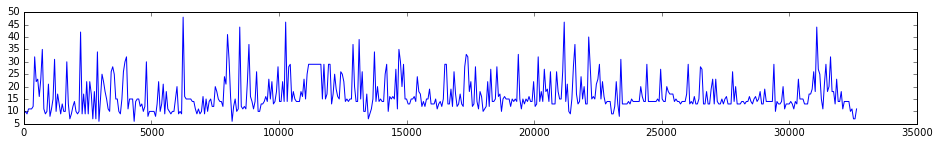

In [87]:
fig = plt.figure(figsize=(16,2))
plt.plot(max_emotes.index, max_emotes.values)